In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as plt

In [2]:
def combine_two_part_ep(two_part_ep):
    for ep in two_part_ep:
        join_ep = []
        path_1 = ("S1/C1E%s-1_FINAL.txt" % ep)
        path_2 = ("S1/C1E%s-2_FINAL.txt" % ep)
        with open(path_1, "r", encoding="latin-1") as p1_ep:
            p1_ep = p1_ep.read().splitlines()
            with open(path_2, "r", encoding="latin-1") as p2_ep:
                p2_ep = p2_ep.read().splitlines()
                join_ep = p1_ep + p2_ep
        with open("S1/C1E%s_FINAL.txt" % ep, 'w', encoding='latin-1') as comb_ep:
            for line in join_ep:
                comb_ep.write('%s\n' % line)

combine_two_part_ep(['035', '033', '031'])

In [3]:
def split_name_speech_count(cont_line):
    name_split = cont_line.index(':')
    name = cont_line[:name_split]

    speak_split = name_split + 2
    speak = cont_line[speak_split:]

    count = len(speak.split())

    split_line = (name, speak, count)
    return split_line


def extract_lines(raw_lines):
    count = 0
    org_list = []
    cont_line = []
    raw_lines = [t for t in raw_lines if t]

    for line in raw_lines:
        line = line.lower()
        remove_char = ['\'', '\"', '.', ',', '?', '/', '!']
        for char in remove_char:
            line = line.replace(char, '')

        count += 1
        if count != len(raw_lines):
            if ':' in line:
                colen_index= line.index(':')
                if colen_index <= 30:
                    if cont_line != []:
                        split_line = split_name_speech_count(cont_line)
                        org_list.append(split_line)
                        cont_line = line
                    else:
                        cont_line = line
            elif org_list == []:
                pass
            else:
                cont_line = cont_line + ' ' + line
        else:
            split_line = split_name_speech_count(cont_line)
            org_list.append(split_line)

    ep_df = pd.DataFrame(org_list, columns =['name', 'speech', 'count'])

    return ep_df


def episode_extract(start_ep, end_ep):
    all_ep_df = pd.DataFrame()
    end_ep += 1
    ep_list = list(range(start_ep,end_ep))
    ep_zfill = [str(ep).zfill(3) for ep in ep_list]
    
    for ep in ep_zfill:
        path = ("S1/C1E%s_FINAL.txt" % ep)
        with open(path, "r", encoding="latin-1") as ep_raw:
            ep_raw = ep_raw.read().splitlines()
            ep_df = extract_lines(ep_raw)
            ep_df['episode'] = ep
            all_ep_df = all_ep_df.append(ep_df)

    return all_ep_df

In [4]:
def mapping_names(all_ep_df):
    laura_name_list = ['all', 'laura', 'vex', '-laura']
    matt_name_list = ['all', 'matt', 'matthew', 'decide', '-matt', 'sherri', 'allura', 'gilmore', 'Adra', 'kima', 'kaylee', 'fast', 'uriel', 'balgus', 'mat', 'caught up']
    marisha_name_list = ['all', 'marisha', 'keyleth', '-marisha']
    sam_name_list = ['all', 'sam', 'scanlan', '-sam']
    taliesin_name_list = ['all', 'taliesin', 'percy', '-taliesin']
    liam_name_list = ['all', 'liam', 'vax', '-liam']
    travis_name_list = ['all', 'travis', 'grog', '-travis']
    ashley_name_list = ['all', 'ashley', 'pike', '-ashley']
    orion_name_list = ['orion', 'tiberius', '-orion']
    guest_name_list = ['zac', 'will', 'mary', 'patrick', 'felicia', 'wil', 'chris', 'jon', 'joe', 'darin', 'noelle', 'kit', 'jason', 'patrick rothfuss']
    break_name_list = ['ify', 'dan', 'brian', 'loves in his life', 'ivan', 'kevin', 'this wonderful show are']

    name_list = [laura_name_list, matt_name_list, 
        marisha_name_list, sam_name_list, taliesin_name_list, 
        liam_name_list, travis_name_list, ashley_name_list, 
        orion_name_list, guest_name_list]

    names = ['laura', 'matt', 
        'marisha', 'sam', 'taliesin', 
        'liam', 'travis', 'ashley', 
        'orion', 'guest']

    for names, name_list in zip(names, name_list):
        all_ep_df[names] = all_ep_df['name'].map(lambda y: 1 if any(word in name_list for word in y.split()) else 0)
    
    return all_ep_df

def combine_name_list(named_mapped_df):
    names = ['laura', 'matt', 
        'marisha', 'sam', 'taliesin', 
        'liam', 'travis', 'ashley', 
        'orion', 'guest']
    named_mapped_df['person_check'] = named_mapped_df[names].sum(axis=1)
    org_names_df = pd.DataFrame()

    for name in names:
        filtered_names_df = named_mapped_df.loc[named_mapped_df[name] == 1]
        filtered_names_df = filtered_names_df[['name', 'speech', 'count', 'episode']]
        filtered_names_df['person'] = name
        org_names_df = org_names_df.append(filtered_names_df)
    
    no_assigned_person = named_mapped_df.loc[named_mapped_df['person_check'] == 0]
    no_assigned_person = no_assigned_person[['name', 'speech', 'count', 'episode']]
    no_assigned_person['person'] = 'no_one'
    org_names_df = org_names_df.append(no_assigned_person)

    return org_names_df

In [5]:
def group_by_person_episode(org_names_df):
    person_episode_group = org_names_df.groupby(['person', 'episode']).agg({'count': ['count', 'sum']})
    person_episode_group = person_episode_group.unstack(level=1, fill_value=0).stack()
    person_episode_group = person_episode_group.unstack(level=-1, fill_value=0).stack().reset_index()
    person_episode_group.columns = ['person', 'episode', 'line_count', 'word_count']
    return person_episode_group

def count_per_episode(person_episode_group):
    cont_l_count = []
    cont_w_count = []
    prev_l_count = 0
    prev_w_count = 0
    prev_name = 'ashley'

    for name, w_count, l_count in zip (person_episode_group['person'], 
        person_episode_group['word_count'],
        person_episode_group['line_count']):

        if name == prev_name:
            prev_l_count += l_count
            cont_l_count.append(prev_l_count)

            prev_w_count += w_count
            cont_w_count.append(prev_w_count)
            
            prev_name = name
        else:
            prev_l_count = l_count
            cont_l_count.append(prev_l_count)

            prev_w_count = w_count
            cont_w_count.append(prev_w_count)
            
            prev_name = name

    person_episode_group['cont_line_count'] = cont_l_count
    person_episode_group['cont_word_count'] = cont_w_count
    
    return person_episode_group

In [6]:
test_df = episode_extract(1, 115)
extract_names = mapping_names(test_df)
org_names_df = combine_name_list(extract_names)
person_episode_group = group_by_person_episode(org_names_df)
count_per_ep = count_per_episode(person_episode_group)

In [7]:
count_per_ep

,person,episode,line_count,word_count,cont_line_count,cont_word_count
0,ashley,001,7,41,7,41
1,ashley,002,0,0,7,41
2,ashley,003,5,6,12,47
3,ashley,004,256,2007,268,2054
4,ashley,005,263,1704,531,3758
...,...,...,...,...,...,...
1260,travis,111,303,2696,26922,198215
1261,travis,112,288,2547,27210,200762
1262,travis,113,337,2445,27547,203207
1263,travis,114,399,3013,27946,206220


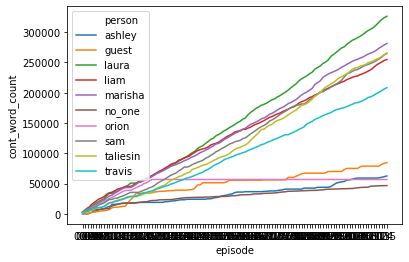

In [10]:
no_matt = count_per_ep.loc[count_per_ep['person'] != 'matt']
sns.lineplot(x="episode", y="cont_word_count", data=no_matt, hue='person')

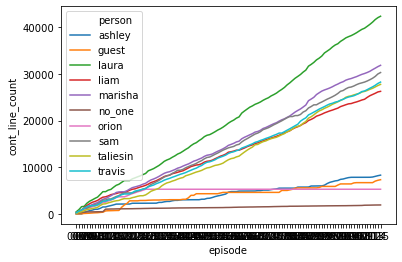

In [11]:
sns.lineplot(x="episode", y="cont_line_count", data=no_matt, hue='person')

In [ ]:
total_names = sum(grouped_names['word_count'])
no_one_count = grouped_names.loc[['no_one']]
no_one_count = sum(no_one_count['word_count'])
print ((total_names - no_one_count)/total_names)